In [1]:
from pathlib import Path
datapath = Path("../master-database-files/master-experimental/questions_about_topics")
datapath.mkdir(parents=True, exist_ok=True)
questionsAndAnswersPath = datapath / "questions_and_answers.json"
answeredMultipleChoiceQuestionsPath = datapath / "answered_multiple_choice_questions.json"
falseAnsweredMultipleChoiceQuestionsPath = datapath / "false_answered_multiple_choice_questions.json"
consistencyCheckPath = datapath / "consistency_check.json"
diversityCheckPath = datapath / "diversity_check.json"
averageDiversityCheckPath = datapath / "average_diversity_check.json"
termlistPath = Path("../master-database-files/master-keyword-extraction/most_important_physics_terms.txt")
termlist = termlistPath.read_text().split("\n")

In [2]:
from os import environ
from pathlib import Path
from json import loads, dumps
from random import choice
environ["OPENAI_API_KEY"] = Path("~/.openaiapikey").expanduser().read_text().strip()
from openai import OpenAI
from random import randint

openaiClient = OpenAI()
def gpt_3_5_turbo_completion(query, temperature = 1):
    answer = openaiClient.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {
                "role": "system",
                "content": query
            }
        ],
        temperature = temperature,
        seed = randint(0, 1000000)
    )
    return answer.choices[0].message.content

def gpt_4_turbo_completion(query, temperature = 1):
    answer = openaiClient.chat.completions.create(
        model="gpt-4-turbo",
        messages=[
            {
                "role": "system",
                "content": query
            }
        ],
        temperature = temperature,
        seed = randint(0, 1000000)
    )
    return answer.choices[0].message.content

def tryRecieveAnswer(query, completionFunction = gpt_3_5_turbo_completion, answerConversion = lambda x: True, maxTries = 10, temperature = 1):
    tryNumber = 0
    while tryNumber < maxTries:
        answer = completionFunction(query, temperature)
        try:
            answer = answerConversion(answer)
            return (answer, True)
        except:
            pass
        tryNumber += 1
    print(f"Failed to recieve answer for query: {query}")
    return (None, False)

def listAnswerConversion(answer):
    result = loads(answer)
    assert isinstance(result, list)
    for item in result:
        assert isinstance(item, str)
    return result

In [39]:
from json import loads, dumps
def generateQuestionsAndAnswers(questionsPerTopic = 30, answersPerQuestion = 5):
    qa = loads(questionsAndAnswersPath.read_text()) if questionsAndAnswersPath.exists() else {}
    for topic in termlist:
        if topic not in qa:
            qa[topic] = {}
        while len(qa[topic]) < questionsPerTopic:
            query = f'Generate a question about the physics topic "{topic}". Return nothing but the question quoted with "".'
            def answerConversion(answer):
                ret = answer.strip()
                assert ret.startswith('"') and ret.endswith('"')
                return ret[1:-1]
            question, success = tryRecieveAnswer(query, answerConversion = answerConversion)
            if not success:
                break
            query = f'''
Generate a list of {answersPerQuestion} statements that answer the question "{question}".
The first statement should be true, the rest should be false.
The false statements should sound plausible to a layman.
Return the list of statements formatted as ["text of the first statement without an indication that it is true", "text of the second statement without an indication that it is false", ...].
Return nothing but the list of statements.
'''
            answer, success = tryRecieveAnswer(query, answerConversion = listAnswerConversion)
            if not success:
                break
            qa[topic][question] = answer
            questionsAndAnswersPath.write_text(dumps(qa, indent = 4))

    

In [40]:
generateQuestionsAndAnswers()

In [41]:
from random import shuffle
def answerMultipleChoiceQuestions():
    qa  = loads(questionsAndAnswersPath.read_text())
    amcq = loads(answeredMultipleChoiceQuestionsPath.read_text()) if answeredMultipleChoiceQuestionsPath.exists() else {}
    for topic, topicContent in qa.items():
        if topic not in amcq:
            amcq[topic] = {}
        for question, answers in topicContent.items():
            if question in amcq[topic]:
                continue
            shuffledAnswers = answers.copy()
            shuffle(shuffledAnswers)
            answersString = "{\n    " + '\n    '.join([f'{i + 1}: "{answer}"' for i, answer in enumerate(shuffledAnswers)]) + "\n}"
            query = f'''
Which of the following statements is the correct answer to the question "{question}"?
{answersString}
Return nothing but the index of the correct answer as a single digit.
'''
            def answerConversion(answer):
                return shuffledAnswers[int(answer) - 1]
            answer, success = tryRecieveAnswer(query, answerConversion = answerConversion)
            if not success:
                continue
            amcq[topic][question] = answer
            answeredMultipleChoiceQuestionsPath.write_text(dumps(amcq, indent = 4))

In [42]:
answerMultipleChoiceQuestions()

In [73]:
def filterFalseAnswers():
    qa  = loads(questionsAndAnswersPath.read_text())
    amcq = loads(answeredMultipleChoiceQuestionsPath.read_text())
    famcq = {}
    for topic, topicContent in amcq.items():
        if topic not in famcq:
            famcq[topic] = {}
        for question, answer in topicContent.items():
            if question not in qa[topic]:
                continue
            answers = qa[topic][question]
            if answer != answers[0]:
                famcq[topic][question] = answer
    falseAnsweredMultipleChoiceQuestionsPath.write_text(dumps(famcq, indent = 4))

In [74]:
filterFalseAnswers()

In [30]:
def calculateConsistency():
    qa  = loads(questionsAndAnswersPath.read_text())
    amcq = loads(answeredMultipleChoiceQuestionsPath.read_text())
    consistency = {}
    for topic, topicContent in qa.items():
        correctlyAnswered = 0
        totalQuestions = 0
        for question, answers in topicContent.items():
            if question in amcq[topic]:
                if amcq[topic][question] == answers[0]:
                    correctlyAnswered += 1
                totalQuestions += 1
        consistency[topic] = correctlyAnswered / totalQuestions * 100
    consistencyCheckPath.write_text(dumps(consistency, indent = 4))

In [68]:
calculateConsistency()

In [43]:
def calculateDiversityScore():
    qa  = loads(questionsAndAnswersPath.read_text())
    diversity = loads(diversityCheckPath.read_text()) if diversityCheckPath.exists() else {}
    for topic, topicContent in qa.items():
        if topic in diversity:
            continue
        questionsString = "{\n    " + '\n    '.join([f'"{question}"' for question in topicContent.keys()]) + "\n}"
        query = f'''
On a scale from 0 to 100, how diverse are the following questions about the physics topic "{topic}"?
{questionsString}
Give them a low score if they are all very similar, and a high score if they are all very different.
return nothing but the score as a single integer.
'''
        def answerConversion(answer):
            ret = int(answer)
            assert 0 <= ret <= 100
            return ret
        answer, success = tryRecieveAnswer(query, answerConversion = answerConversion)
        if not success:
            continue
        diversity[topic] = int(answer)
        diversityCheckPath.write_text(dumps(diversity, indent = 4))

In [51]:
def calculateAverageDiversityScore(repeats = 5):
    qa  = loads(questionsAndAnswersPath.read_text())
    diversity = loads(averageDiversityCheckPath.read_text()) if averageDiversityCheckPath.exists() else {}
    for topic, topicContent in qa.items():
        if topic in diversity:
            continue
        numberOfRepeats = 0
        totalDiversity = 0
        for i in range(repeats):
            questionsString = "{\n    " + '\n    '.join([f'"{question}"' for question in topicContent.keys()]) + "\n}"
            query = f'''
On a scale from 0 to 100, how diverse are the following questions about the physics topic "{topic}"?
{questionsString}
Give them a low score if they are all very similar, and a high score if they are all very different.
return nothing but the score as a single integer.
'''
            def answerConversion(answer):
                ret = int(answer)
                assert 0 <= ret <= 100
                return ret
            answer, success = tryRecieveAnswer(query, answerConversion = answerConversion)
            if not success:
                continue
            totalDiversity += int(answer)
            numberOfRepeats += 1
        diversity[topic] = totalDiversity / numberOfRepeats
        averageDiversityCheckPath.write_text(dumps(diversity, indent = 4))

In [53]:
calculateAverageDiversityScore()

In [35]:
def removeTermsThatAreNotInTheTermList():
    qa = loads(questionsAndAnswersPath.read_text())
    amcq = loads(answeredMultipleChoiceQuestionsPath.read_text())
    for topic in list(qa.keys()):
        if topic not in termlist:
            del qa[topic]
    for topic in list(amcq.keys()):
        if topic not in termlist:
            del amcq[topic]
    questionsAndAnswersPath.write_text(dumps(qa, indent = 4))
    answeredMultipleChoiceQuestionsPath.write_text(dumps(amcq, indent = 4))

In [38]:
removeTermsThatAreNotInTheTermList()

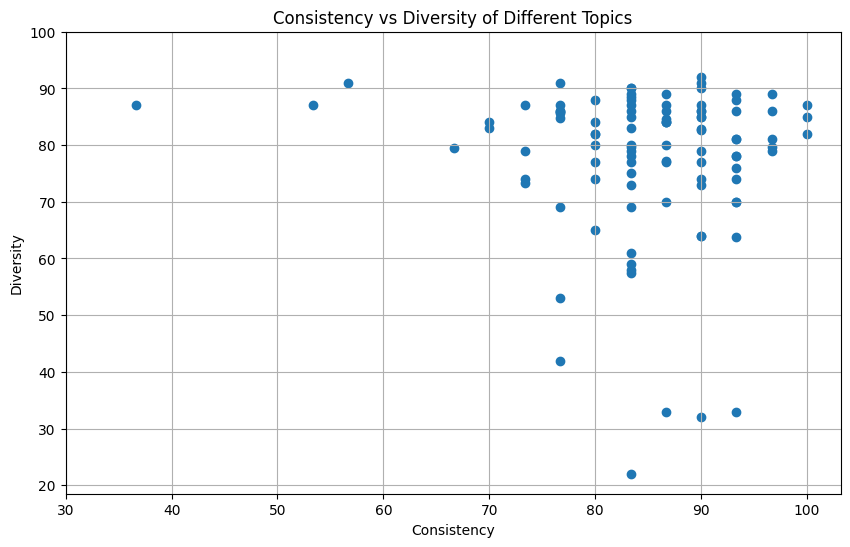

In [56]:
import json

from adjustText import adjust_text

import matplotlib.pyplot as plt

# Read the data from the files
consistency_data = json.loads(consistencyCheckPath.read_text())
diversity_data = json.loads(averageDiversityCheckPath.read_text())

# Extract the topics and corresponding consistency and diversity values
topics = list(consistency_data.keys())
consistency_values = list(consistency_data.values())
diversity_values = list(diversity_data.values())

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(consistency_values, diversity_values)
plt.ylabel('Diversity')
plt.xlabel('Consistency')
plt.title('Consistency vs Diversity of Different Topics')
plt.yticks(range(20, 101, 10))
plt.xticks(range(30, 101, 10))
plt.grid(True)
plt.show()

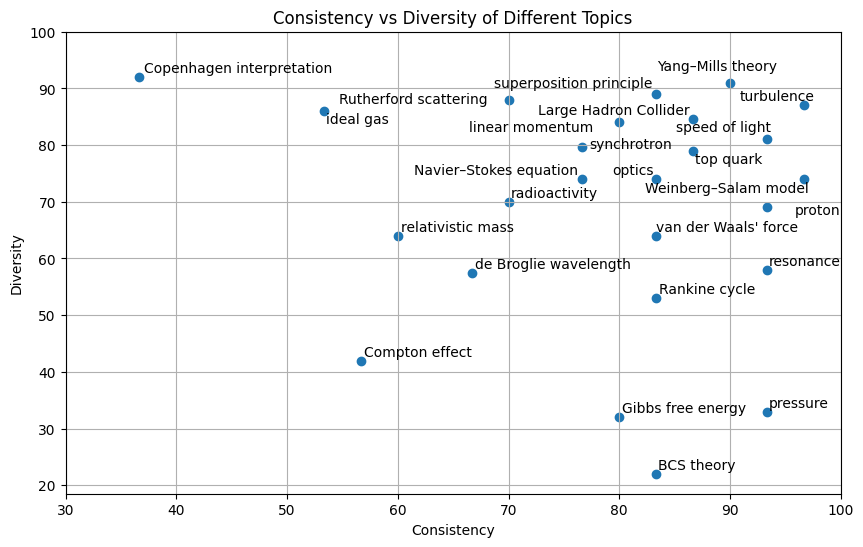

In [3]:
import json
from adjustText import adjust_text

import matplotlib.pyplot as plt

# Read the data from the files
consistency_data = json.loads(consistencyCheckPath.read_text())
diversity_data = json.loads(averageDiversityCheckPath.read_text())

# Extract the topics and corresponding consistency and diversity values
topics = []
consistency_values = []
diversity_values = []

for topic in [*consistency_data][::-1]:
    if topic in diversity_data:
        # Only include the values if the datapoint is not to close to an existing one
        min_distance = 100
        for i in range(len(topics)):
            distance = (consistency_data[topic] - consistency_values[i])**2 + (diversity_data[topic] - diversity_values[i])**2
            min_distance = min(min_distance, distance)
        if min_distance > 30:
            topics.append(topic)
            consistency_values.append(consistency_data[topic])
            diversity_values.append(diversity_data[topic])

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(consistency_values, diversity_values)
plt.ylabel('Diversity')
plt.xlabel('Consistency')
plt.title('Consistency vs Diversity of Different Topics')
plt.yticks(range(20, 101, 10))
plt.xticks(range(30, 101, 10))
plt.grid(True)

# Add labels to the data points
texts = []
for i, topic in enumerate(topics):
    texts.append(plt.text(consistency_values[i], diversity_values[i], topic))

# Adjust the position of the labels to avoid overlap
adjust_text(texts)

plt.savefig(str(datapath / "consistency_vs_diversity.svg"))
plt.savefig(str(datapath / "consistency_vs_diversity.pdf"))

plt.show()

In [62]:
def sortTermsByDiversity():
    diversity = loads(averageDiversityCheckPath.read_text())
    sortedTerms = sorted(termlist, key = lambda x: diversity[x], reverse = True)
    for i, term in enumerate(sortedTerms):
        print(f"{diversity[term]:.2f}: {term}")

In [63]:
sortTermsByDiversity()

92.00: Copenhagen interpretation
91.00: conservation law
91.00: uncertainty principle
91.00: Yang–Mills theory
90.00: big-bang theory
90.00: Boyle's law
90.00: dark energy
89.00: Ohm's law
89.00: Planck constant
89.00: special theory of relativity
89.00: superposition principle
88.40: Newton's law of gravitation
88.00: M-theory
88.00: Poisson distribution
88.00: Rutherford scattering
87.00: angular momentum
87.00: Archimedes' principle
87.00: Bose–Einstein condensation
87.00: CPT theorem
87.00: Doppler effect
87.00: field
87.00: inverse-square law
87.00: turbulence
86.00: Dirac equation
86.00: ideal gas
86.00: Lagrangian
86.00: Noether's theorem
86.00: physics
86.00: thermodynamics
86.00: thermonuclear reaction
86.00: W boson
85.80: Atomic Theory
85.60: Heisenberg uncertainty principle
85.00: active galactic nucleus
85.00: diamagnetism
85.00: frame of reference
85.00: Snell's law
84.80: Carnot cycle
84.60: Large Hadron Collider
84.00: Cerenkov radiation
84.00: isotope
84.00: linear mom

In [66]:
def sortTermsByConsistency():
    consistency = loads(consistencyCheckPath.read_text())
    sortedTerms = sorted(termlist, key = lambda x: consistency[x], reverse = True)
    for i, term in enumerate(sortedTerms):
        print(f"{consistency[term]:.2f}: {term}")

In [69]:
sortTermsByConsistency()

100.00: active galactic nucleus
100.00: Archimedes' principle
100.00: Heisenberg uncertainty principle
96.67: Fabry–Pérot interferometer
96.67: Higgs boson
96.67: Newton's law of gravitation
96.67: Noether's theorem
96.67: turbulence
96.67: Weinberg–Salam model
93.33: general theory of relativity
93.33: perturbation theory
93.33: Planck constant
93.33: pressure
93.33: proton
93.33: quantum mechanics
93.33: resonance
93.33: Schrödinger equation
93.33: SI units
93.33: speed of light
93.33: thermonuclear reaction
93.33: W boson
90.00: Boyle's law
90.00: calculus
90.00: conservation law
90.00: fluid mechanics
90.00: fundamental interactions
90.00: inverse-square law
90.00: magnetic field
90.00: microwave background radiation
90.00: Pauli exclusion principle
90.00: special theory of relativity
90.00: strong interaction
90.00: thermodynamics
90.00: uncertainty principle
90.00: Yang–Mills theory
86.67: Cerenkov radiation
86.67: density functional theory
86.67: Einstein equation
86.67: entropy